# Figure 3

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pylab as plt
import time

from copy import deepcopy
import sys
sys.path.append("../../../setup")
sys.path.append("../../../simulator")
sys.path.append("../../../inference")
sys.path.append("../../../utils")
sys.path.append("../model/")
sys.path.append('../../')

from common import col, svg, samples_nd, get_labels_8pt
import netio
import viz
import importlib
from compare_samples import get_dist, evaluate_summ_stats
from find_pyloric import merge_samples, params_are_bounded
import dill as pickle
from find_pyloric import merge_datasets, merge_datasets_energy, find_pyloric_like, find_close_to_obs
import matplotlib as mpl

In [3]:
PANEL_A = '../svg/panel_a.svg'
PANEL_B = '../svg/panel_b.svg'
PANEL_C = '../svg/panel_c.svg'

### Load experimental data

In [4]:
params_11 = netio.load_setup('collect_31D')

prior_11 = netio.create_prior(params_11, log=True)
dimensions_11 = np.sum(params_11.use_membrane) + 7
lims_11 = np.asarray([-np.sqrt(3)*np.ones(dimensions_11), np.sqrt(3)*np.ones(dimensions_11)]).T

params_mean_11 = prior_11.mean
params_std_11 = prior_11.std

params_11.model_params['temp'] = 283
pyloric_sim_11 = netio.create_simulators(params_11, save_all_energies=True)
energy_calc = netio.create_energy(params_11)

('seed in cHH', None)


In [5]:
data = np.load('../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz')
good_stats = data['sample_stats']
good_params = data['sample_params']
good_seeds = data['sample_seeds']

In [6]:
sample_params = good_params
sample_stats = good_stats
print('There are', len(good_seeds), 'datapoints in this dataset')

There are 55043 datapoints in this dataset


In [7]:
sample_stats = data['sample_stats']
sample_params = data['sample_params']
sample_seeds = data['sample_seeds']

In [8]:
energies = sample_stats[:, 21:24]
summed_energies = np.sum(energies, axis=1)

### Quantify the variances

In [9]:
prior_range = prior_11.upper - prior_11.lower

In [10]:
inds = np.argsort(summed_energies)
sorted_energies = np.sort(summed_energies)
sorted_params = sample_params[inds]
sorted_ss = sample_stats[inds]

In [11]:
all_means = []
for quantile in [0.99, 0.75, 0.5, 0.25, 0.01]:

    sample_stats = data['sample_stats']
    sample_params = data['sample_params']
    sample_seeds = data['sample_seeds']

    num_samples = 1000
    num_vals = len(summed_energies)
    params_to_plot = sorted_params[int(num_vals*quantile - num_samples/2):int(num_vals*quantile + num_samples/2)]
    energy_thr = sorted_energies[int(num_vals*quantile)]
    
    mean_of_these_params = np.mean(params_to_plot, axis=0)
    all_means.append(mean_of_these_params)
all_means = np.asarray(all_means)

In [12]:
energy_thr

1721441.8802888643

### Plot histogram

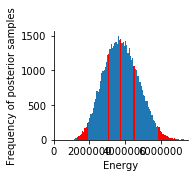

In [13]:
fig, ax = plt.subplots(1,1, figsize=(2.4,2))
    
N, bins, patches = ax.hist(summed_energies, bins=100)
    
for quantile in [0.99, 0.75, 0.5, 0.25, 0.01]:
    sample_stats = data['sample_stats']
    sample_params = data['sample_params']
    sample_seeds = data['sample_seeds']

    num_samples = 1000
    num_vals = len(summed_energies)
    params_to_plot = sorted_params[int(num_vals*quantile - num_samples/2):int(num_vals*quantile + num_samples/2)]
    energy_thr_low = sorted_energies[int(num_vals*quantile - num_samples/2)]
    energy_thr_high = sorted_energies[int(num_vals*quantile + num_samples/2)]
        
    for i, b in enumerate(bins):
        if b > energy_thr_low and b < energy_thr_high:
            patches[i].set_facecolor('r')
    
ax.set_xlim(0, 7500000)
ax.set_xlabel("Energy")
ax.set_ylabel("Frequency of posterior samples")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.savefig('../results/energy/figs_new/histogram.png', dpi=300, bbox_inches='tight')

In [14]:
shift_in_mean = all_means[0] - all_means[-1]
shift_in_mean_normalized = shift_in_mean/prior_range

In [15]:
sort_inds = np.argsort(np.abs(shift_in_mean_normalized))
strongest_variation_inds = np.sort(sort_inds[-8:]) # these are used for plots

In [16]:
labels_ = get_labels_8pt(params_11)
labels_[9] += ''

In [17]:
from decimal import Decimal
all_labels = []
lims=lims_11
params_std = params_std_11
params_mean = params_mean_11
for dim_i in range(31):
    if dim_i > len(params_mean_11) - 7.5: # synapses
        if dim_i == 24: all_labels.append([r'$\mathdefault{0.01}$     ', r'$\mathdefault{10000}\;\;\;\;$   '])
        else: all_labels.append([r'$\mathdefault{0.01}$ ', r'$\mathdefault{1000}\;\;\;\;$ '])
    else: # membrane conductances
        num_after_digits = -int(np.log10(lims[dim_i, 1] * params_std[dim_i] + params_mean[dim_i]))
        if num_after_digits > 2:
            num_after_digits=2
        labels = [round(Decimal((lims[dim_i, num_tmp] * params_std[dim_i] + params_mean[dim_i]) / 0.628e-3), num_after_digits)
                  for num_tmp in range(2)]
        new_labels = []
        counter=0
        for l in labels:
            if counter == 0:
                new_labels.append(r'$\mathdefault{'+str(l)+'}$  ')
            else:
                new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;$  ')
            counter+=1
        all_labels.append(new_labels)

# Panel A: posterior for parameters that change a lot

energy_thr 5845257.641395471 6811771.800065166
energy_thr 1283508.8495112432 1894319.0407199033


../model/viz.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts['labels'] == [] or opts['labels'] is None:


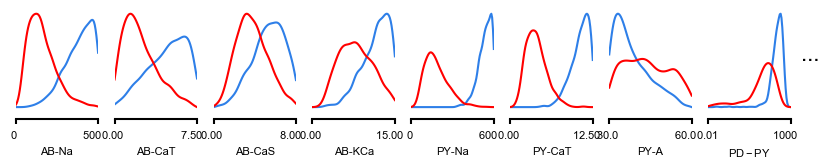

In [18]:
all_sample_params = []

for i, quantile in enumerate([0.99, 0.01]):
    sample_stats = data['sample_stats']
    sample_params = data['sample_params']
    sample_seeds = data['sample_seeds']

    num_samples = 1000
    num_vals = len(summed_energies)
    params_to_plot = sorted_params[int(num_vals*quantile - num_samples/2):int(num_vals*quantile + num_samples/2)]
    energy_thr_low = sorted_energies[int(num_vals*quantile - num_samples/2)]
    energy_thr_high = sorted_energies[int(num_vals*quantile + num_samples/2)]
    print("energy_thr", energy_thr_low, energy_thr_high)

    sample_params = (params_to_plot - params_mean_11) / params_std_11
    all_sample_params.append(sample_params)

with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, axes = viz.oneDmarginal(samples=all_sample_params,
                           subset=strongest_variation_inds.tolist(),
                           limits=lims,
                           ticks=lims,
                           tick_labels=all_labels,
                           fig_size=(10, 1.3),
                           labels=labels_,
                           samples_colors=[col['SNPE'], 'r'],
                           diag=['kde', 'kde'],
                           hist_offdiag={'bins':50})
    plt.savefig(PANEL_A, facecolor='None', transparent=True)
    plt.show()

# Panel B: posterior for parameters that barely change

In [19]:
sort_inds = np.argsort(np.abs(shift_in_mean_normalized))
weakest_variation_inds = np.sort(sort_inds[:8]) # these are used for plots

../model/viz.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts['labels'] == [] or opts['labels'] is None:


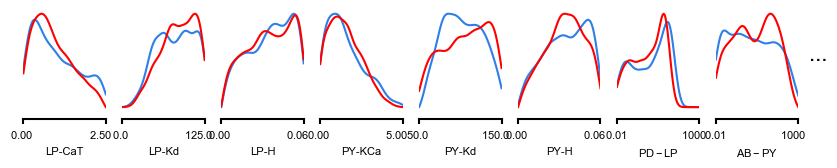

In [20]:
all_sample_params = []

for i, quantile in enumerate([0.99, 0.01]):
    sample_stats = data['sample_stats']
    sample_params = data['sample_params']
    sample_seeds = data['sample_seeds']

    num_samples = 1000
    num_vals = len(summed_energies)
    params_to_plot = sorted_params[int(num_vals*quantile - num_samples/2):int(num_vals*quantile + num_samples/2)]

    sample_params = (params_to_plot - params_mean_11) / params_std_11
    all_sample_params.append(sample_params)

with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, axes = viz.oneDmarginal(samples=all_sample_params,
                           subset=weakest_variation_inds.tolist(),
                           limits=lims,
                           ticks=lims,
                           tick_labels=all_labels,
                           fig_size=(10, 1.3),
                           labels=labels_,
                           samples_colors=[col['SNPE'], 'r'],
                           diag=['kde', 'kde'],
                           hist_offdiag={'bins':50})
    plt.savefig(PANEL_B, facecolor='None', transparent=True)
    plt.show()

# Panel C: summarize

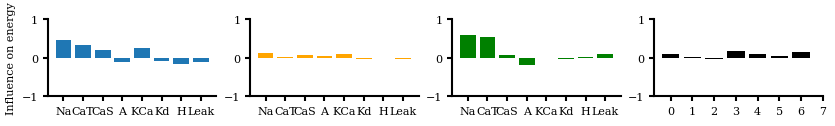

In [21]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.sensitivity_hist(shift_in_mean_normalized, figsize=(10,1))
    plt.savefig(PANEL_C, facecolor='None', transparent=True)

# Assemble figure

In [22]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [23]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "11.0cm",

    Panel(
          SVG(PANEL_A).scale(svg_scale).move(0, 0*factor_svg),
          Text("a", 0.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 0*factor_svg),
    
    Panel(
        SVG(PANEL_B).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("b", 0.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 28*factor_svg),
    
    Panel(
          SVG(PANEL_C).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("c", 0.0*factor_svg, 2.0*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 56*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3.svg")
svg('../fig/fig3.svg')